In [4]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

import matplotlib.pyplot as plt

class Kernel_calculator():
    
    # This is a class that is used to calculate the discrete nonlocal model of any order by the method that is described
    # in my paper
    
    def __init__(self,Eh,Es,rhoh,rhos):
        
        # material mechanic properties
        self.Eh = Eh
        self.Es = Es
        self.rhoh = rhoh
        self.rhos = rhos
        
        
        # material geometric properties right now we don't plan to change the geometry of the microstructure
        self.alpha = 0.25
        self.beta = 0.5
        self.l = 0.02
        
    def lineq_solver(self,xi,order):
        
        #Use least square to solve Ax=b in the microstructure of the material
        
        # Right now only when order is an even number and <= 6, this works pretty well *************
        
        N = 1+3*(order+1)
        A = np.zeros((N,N),dtype=np.complex)
        b = np.zeros(N)
        alpha = self.alpha
        beta = self.beta
        l = self.l
        
        Eh = self.Eh/self.Es # since only the ratio matters, this will make computation better
        Es = 1
        rhoh = self.rhoh
        rhos = self.rhos
        #initiate first several equations at the interfaces
        A[0,0] = alpha
        A[0,order+1] = beta
        A[0,2*order+3] = alpha
        b[0] = 1
        
        for i in range(order+1):
            A[0,i] = alpha**(i+1)*l**i/(i+1)
            A[0,2*order+3+i] = alpha**(i+1)*l**i/(i+1)
        
        for i in range(order+2):
            A[0,order+1+i] = beta**(i+1)*l**i/(i+1)
            
        A[1,0] = -np.exp(1j*2*np.pi*l*xi)
        A[2*order+3,2*order+3] = -1
        A[order+2,order+1] = -1
        
        for i in range(order+1):
            A[1,2*order+3+i] = alpha**i*l**i
            A[order+2,i] = alpha**i*l**i
            
        for i in range(order+2):
            A[2*order+3,order+1+i] = beta**i*l**i
            
        
        # then iterate to generate the result of the linear equations
            
        for i in range(order):
            A[i+2,i+1] = A[i+1,i]*(i+1)
            for k in range(i+1,order+1):
                A[i+2,2*order+3+k] = A[i+1,2*order+3+k]*(k-i)/alpha/l
        
        for i in range(order):
            if i%2 == 0:
                Erhoh = Eh
                Erhos = Es
            else:
                Erhoh = 1./rhoh
                Erhos = 1./rhos
            
            A[2*order+4+i,2*order+4+i] = Erhoh*A[2*order+3+i,2*order+3+i]*(i+1)
            for k in range(i+1,order+2):
                A[2*order+4+i,order+1+k] = Erhos*A[2*order+3+i,order+1+k]*(k-i)/beta/l
        
        for i in range(order):
            if i%2 == 0:
                Erhoh = Eh
                Erhos = Es
            else:
                Erhoh = 1./rhoh
                Erhos = 1./rhos
            
            A[order+3+i,order+2+i] = Erhos*A[order+2+i,order+1+i]*(i+1)
            for k in range(i+1,order+1):
                A[order+3+i,k] = Erhoh*A[order+2+i,k]*(k-i)/alpha/l
                
        sol = np.linalg.lstsq(A,b,rcond=-1)
                
        return sol
    
    def fitting_kernel_formular(self,order,upperbound = None):
        
        # Since matrix A in lineq_solver could be rank-deficient if xi is around 1/(2l), therefore we cannot directly use
        # the function lineq_solver to do the integration to find out the Fourier coefficients. But we are fortunate
        # enought to know the general symbolic expression for the result. Therefore, we do a formular fitting to avoid
        # the matrix being singular in lineq_solver
        
        oorder = 2*int((order+1)/2) # tempory vairable for treating the odd number of order the same way as even number order
        
        N = oorder  # number of coefficients in the formular that needs to be fitted
        
        if upperbound == None:
            xi = np.linspace(1/(1+2**(order/2))/self.l/2/N,1/(1+2**(order/2))/self.l,2*N) # the number of samples that I pick is 8N inside the interval, the upper bond may not be the best upper bond****
        # more comments: by some testing, the upper bond may even depend on the value of rhoh, rhos due to numerical accuracy
        # This sample picking process still needs a lot of improvement in order to be robust**************Right now it seems to work fine for rho=8000
        else:
            xi = np.linspace(upperbound/self.l/2/N,upperbound/self.l,2*N)
        # Since we know the exact form of the formluar, we don't need optimization to do the fitting, we can simply solve
        # an overdetermined linear equations system.
        
        #Constructing the A in Ax=b, where A is 2N*N
        A = np.zeros((2*N,N))
        b = np.zeros(2*N)
        for i in range(2*N):
            x = xi[i]
            
            kernel_sol = 0 # kernel_sol will be the exact result of the kernel calculated by lineq_solver
            
            # extracting the final result of kernel from the solution of lineq_solver
            sol = self.lineq_solver(x,order)[0]
            kernel_sol = sol[1]/(1-np.exp(-1j*2*np.pi*self.l*x))
            real_kernel_sol = kernel_sol.real
                
            #assigning values to A              
            for k in range(int(oorder/2)):
                A[i,k] = np.cos(2*np.pi*self.l*x*k)
            
            for k in range(int(oorder/2)):
                A[i,k+int(oorder/2)] = -np.cos(2*np.pi*self.l*x*k)*real_kernel_sol
            
            b[i] = np.cos(2*np.pi*self.l*x*(oorder/2))*real_kernel_sol
        
        kernel_coeff = np.linalg.lstsq(A,b,rcond=-1) # use least square to sovle this overdetermine linear equations
        
        return kernel_coeff
    
    def frequency_kernel_func(self,xi,order,coeff,upperbound = None):
        
        # This is the function of plugging the kernel_coeff calculated by fitting_kernel_formular into the formular of
        # kernel. this function is not combined with the function below for testing reasons
        
        numer = 0
        oorder = 2*int((order+1)/2) # tempory vairable for treating the odd number of order the same way as even number order
        temp = np.cos(2*np.pi*self.l*xi*(int(oorder/2))) # temporary variable for calculating the denominator
        #coeff = self.fitting_kernel_formular(order,upperbound = upperbound)[0]
        for i in range(int(oorder/2)):
            numer += coeff[i]*np.cos(2*np.pi*self.l*xi*i) #calculating the numerator
        
        for i in range(int(oorder/2)):
            temp += coeff[i+int(order/2)]*np.cos(2*np.pi*self.l*xi*i) #calculating the denominator
            
        return numer*(np.cos(2*np.pi*self.l*xi*1)-1)*2/temp
    
    def fourier_kernel_func(self,xi,order,n,coeff,upperbound = None):
        
        # this is the function of frequency_kernel_func timing cos(2pi l xi) to prepare for the integration to calculate the fouriers coeffecients
        
        
        return self.frequency_kernel_func(xi,order,coeff,upperbound = None)*np.cos(2*np.pi*n*self.l*xi)
            

    def discrete_kernel_calculator(self, order, n, upperbound = None):
        
        #integration to calculatet the discrete_kernel
        
        coeff = self.fitting_kernel_formular(order,upperbound = upperbound)[0] #first calculate the fitting coefficients
        
        discrete_kernel = integrate.quad(self.fourier_kernel_func,0,1/self.l, args=(order,n,coeff))
        
        return discrete_kernel
    
    def plot_test(self,order,upperbound = None):
        
        # This is used to plot for testing the fourier_kernel_func that needs to be integrated to get the discrete kernel.
        # If there are singularities in the plots, then some parameters in the fitting function have to be changed
        
        coeff = self.fitting_kernel_formular(order,upperbound = upperbound)[0] #first calculate the fitting coefficients
        
        size = 1000
        x = np.linspace(0,1/self.l,size)  
        y = np.linspace(0,1/self.l,size)
        
        for i in range(size):
            y[i] = self.frequency_kernel_func(x[i],order,coeff,upperbound = upperbound)
        plt.plot(x,y)
        
    def kernel_generator(self,order,tolerance):
        
        # This is used to directly generate an array of discrete kernel that can be directly used for simulation
        
        # assign first 2 dicrete value to any order of the kernel
        nonlocal_kernel = np.zeros(2)
        for i in range(2):
            nonlocal_kernel[i] = self.discrete_kernel_calculator(order,i+1)[0]
            
        ratio = 1
        i = 2
        # if the ratio is too big then it means we need include more discrete kernels
        while ratio > 1e-3: 
            # we assign at least 4 discrete kernels in total
            nonlocal_kernel = np.append(nonlocal_kernel,self.discrete_kernel_calculator(order,i+1)[0])
            nonlocal_kernel = np.append(nonlocal_kernel,self.discrete_kernel_calculator(order,i+2)[0])
            ratio = nonlocal_kernel[i]/nonlocal_kernel[0]
            i+=2
        
        return nonlocal_kernel
        
    
        
        


In [5]:
mytest = Kernel_calculator(200,5,8000,8000)

In [10]:
f = mytest.plot_test(1,upperbound = 1/8)
f.subplots().show()

AttributeError: 'AxesSubplot' object has no attribute 'show'

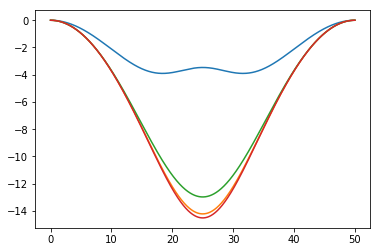

In [167]:
mytest.plot_test(3)
mytest.plot_test(4)
mytest.plot_test(2)
mytest.plot_test(6)
plt.show()

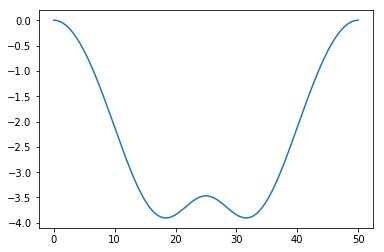

In [9]:
mytest.plot_test(3)

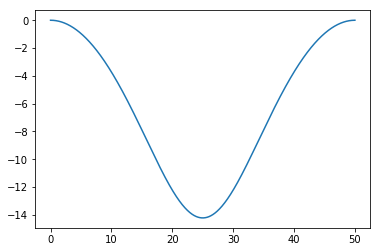

In [168]:
mytest.plot_test(4)

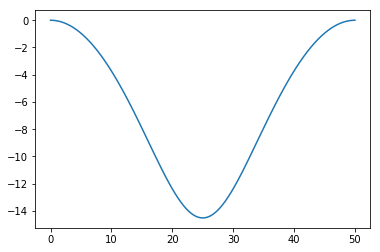

In [13]:
mytest.plot_test(6)